# Basic example using the MOGPTK

One fundamental pillar of MOGPTK are the data and model classes, where one stores the data for each channel and the other defines the model to use. In this tutorial we will show how to instanciate them and use them for a toy dataset.

This tutorial show examples for: __MOSM, CONV, CSM__ and __SM-LMC__ kernels

In [1]:
# import library if it is not installed
import sys
sys.path.insert(0, '../')

import mogptk

import numpy as np
import matplotlib.pyplot as plt

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

## 1. Generate dataset

As a toy example we generate three sinusoidal signals. The four sinusses are each put in a channel and have the same frequency but differ in phase and delay. The observations are randomly picked in the range of [0,4], where the first channel will have the second half of the observations removed. The second channel will be a phased-delayed version, the third will have a second sinusoidal, and the fourth will have a time-delay.

In [2]:
# create data points

# time array
n_points = 60
t = np.linspace(0, 4, n_points)

# data for channel 1
y1 = np.sin(6 * t)
# add noise
y1 += np.random.normal(scale=0.1, size=len(t))

# phased version
y2 = np.sin(6 * t + 2)
y2 += np.random.normal(scale=0.1, size=len(t))

# added sinosoidal
y3 = np.sin(6 * t) - np.sin(4 * t)
y3 += np.random.normal(scale=0.1, size=len(t))

# delayed and amplified
y4 = 3 * np.sin(6 * (t - 2))
y4 += np.random.normal(scale=0.1, size=len(t))

Then for each time series (channels) we will create a data class object, and then we will create a list of data objects.

In [3]:
data_list = []

# data object
data = mogptk.Data(t, y1, name='A')
data_list.append(data)

data = mogptk.Data(t, y2, name='B')
data_list.append(data)

data = mogptk.Data(t, y3, name='C')
data_list.append(data)

data = mogptk.Data(t, y4, name='D')
data_list.append(data)

Then we can remove the seconf half for the channel 'A' and randomly remove 40% for each channel

In [4]:
# remove randomly
for data in data_list:
    data.remove_randomly(pct=0.3)

# remove for channel 0
data_list[0].remove_range(start=2.0, end=None)

We can plot the values a power spectral density of the data easily

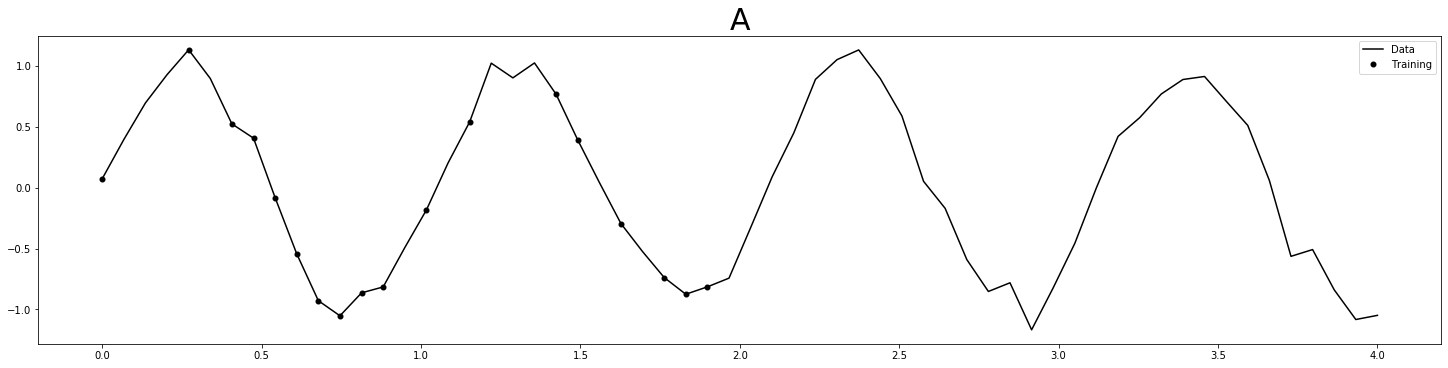

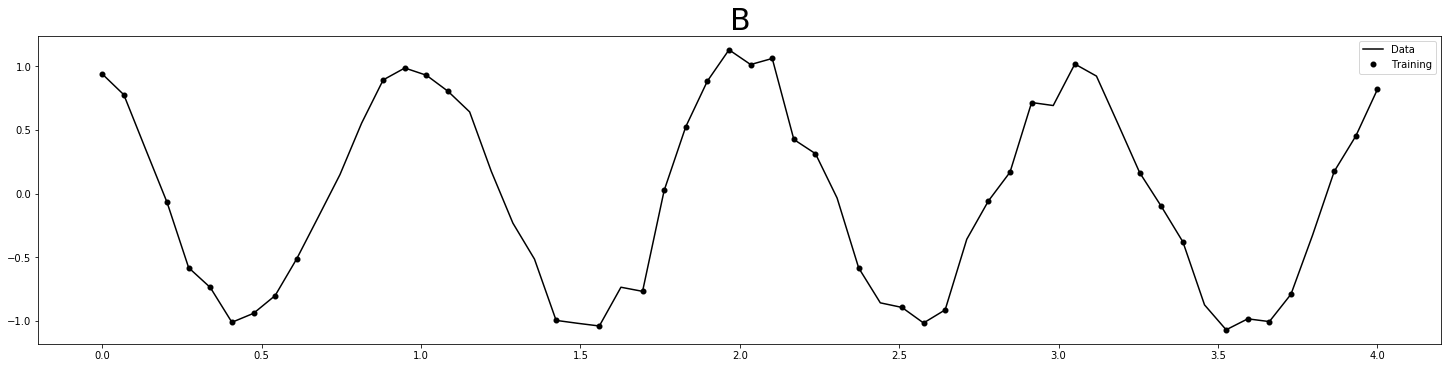

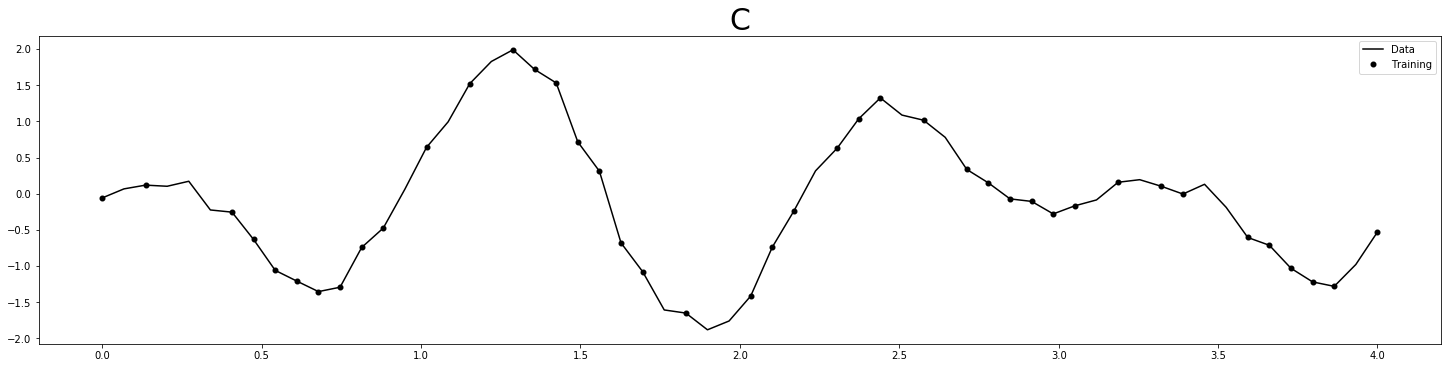

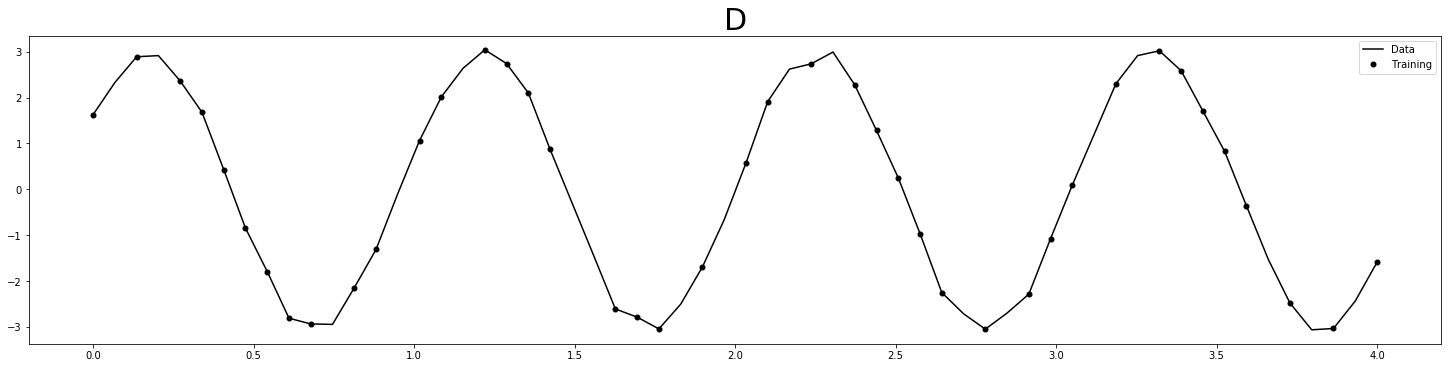

In [5]:
# plot data in time
for data in data_list:
    data.plot()

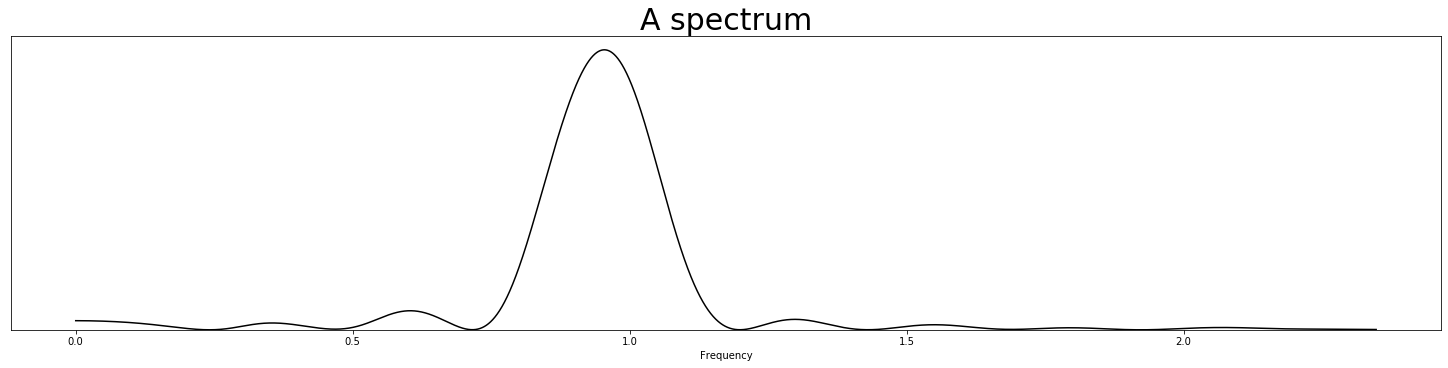

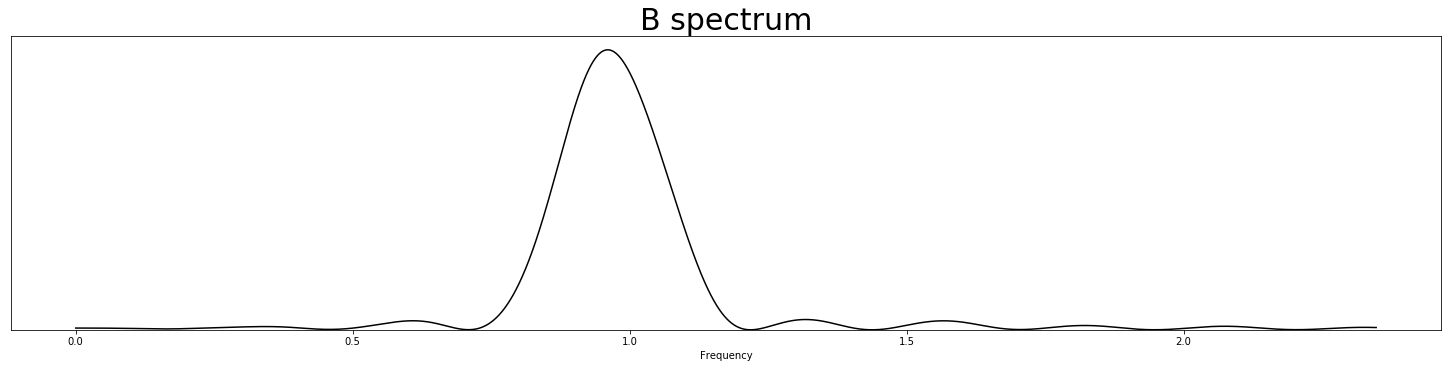

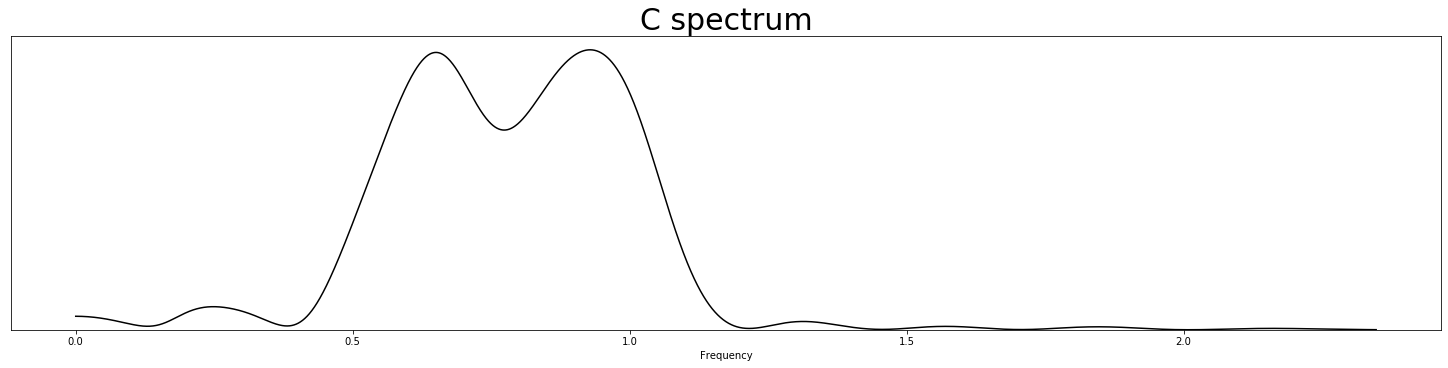

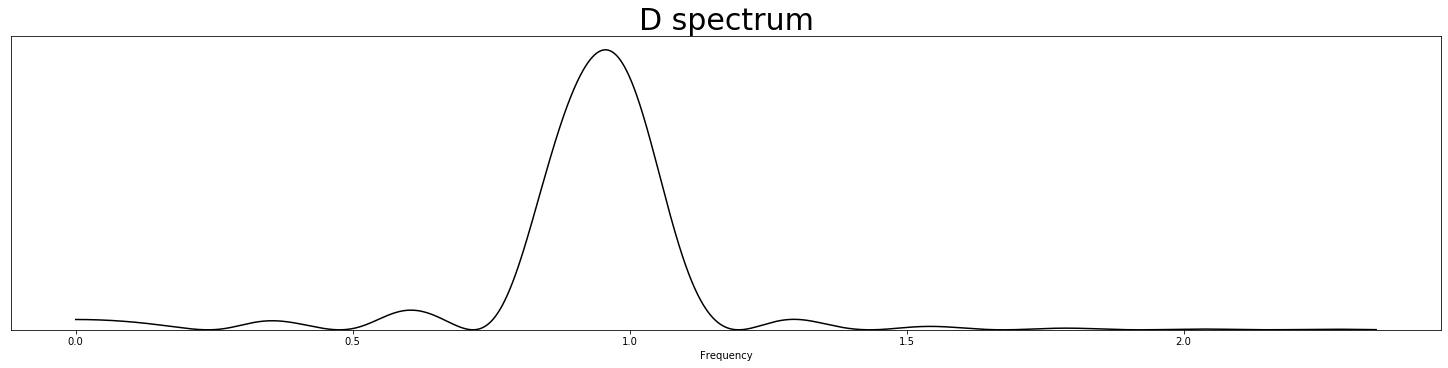

In [6]:
# plot spectrum
for data in data_list:
    data.plot_spectrum()

With the data objects we can use any of the models of the toolkit

## 2.Models

To use a model we first create the object, then we can initialize the parameters and train/predict with ease

When we create the object, we have to pass the data list and the number of components. Initially the kernel parameters are at random, but we can __optionally__ re-initialize them by:

1. 'BNSE': Estimate the PSD for each channel via BNSE (bayesian non parametric spectral estimation, Tobar 2019), then utilize the position, magnitude and with of the estimated spectrum as spectral means, weights and variance respectively.

2. 'SM': For each channel adjust a single output Gaussian process with spectral mixture kernel, and use said parameters as initial parameters for the kernel.

In [7]:
# create model

model = mogptk.MOSM(data_list, Q=2)
# model = mogptk.CSM(data_list, Q=2)
# model = mogptk.SMLMC(data_list, Q=2)
# model = mogptk.CG(data_list, Q=2)

# initialize parameters of kernel
model.init_params('BNSE')

With the model initialized we can obtain a preliminary prediction __before__ training

Text(0.5, 1.03, 'Untrained model')

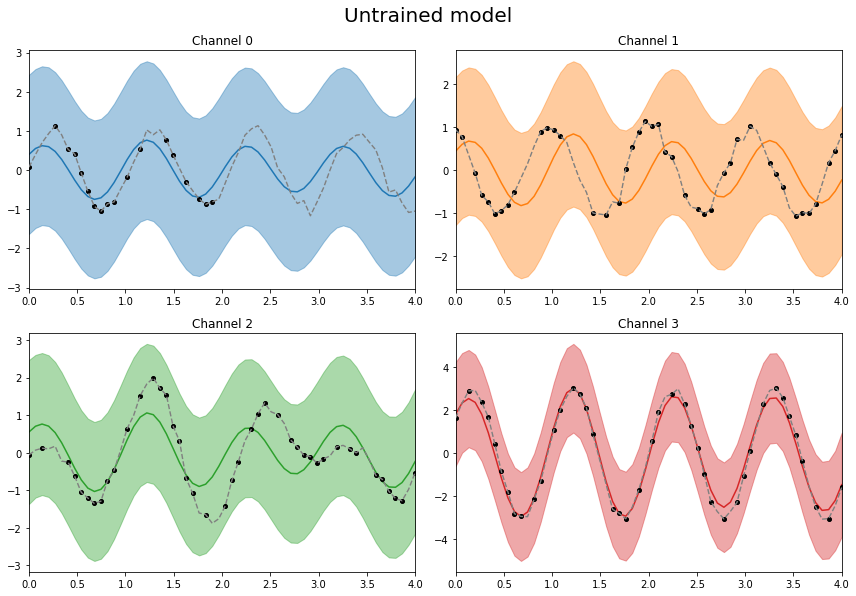

In [8]:
# construct the gpflow model
model.build()

# plot the prediction with untrained model
_ = mogptk.plot_prediction(model)
plt.suptitle('Untrained model', y=1.03, fontsize=20)

The model can be trained using tensorflow of scipy optimizers

In [9]:
model.train(
    method='L-BFGS-B',
    tol=1e-6,
    maxiter=2000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -108.965840
  Number of iterations: 892
  Number of functions evaluations: 992
Done in  0.9278429706891378  minutes


Text(0.5, 1.03, 'Trained model')

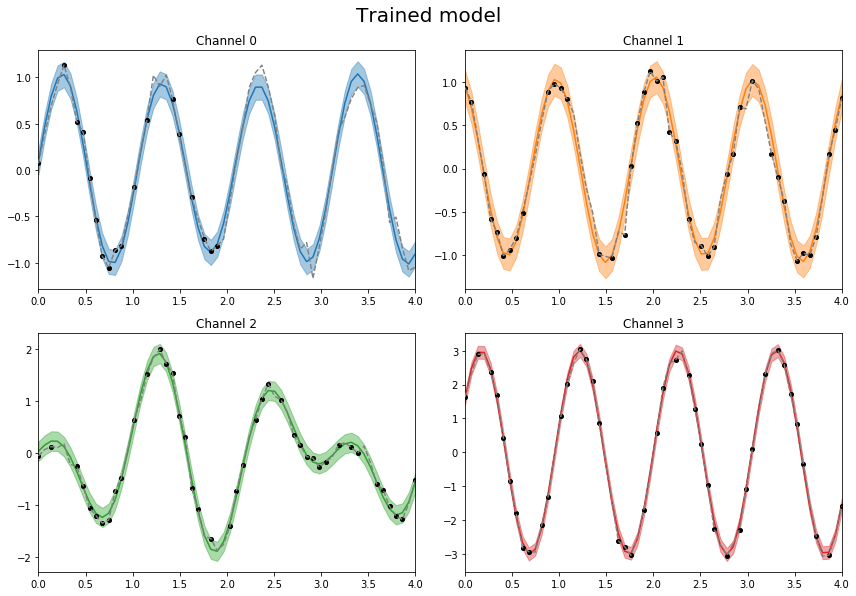

In [10]:
_ = mogptk.plot_prediction(model)
plt.suptitle('Trained model', y=1.03, fontsize=20)